In [1]:
library(ontologyIndex)
library(ontologySimilarity)
library(reshape2)
library(pheatmap)
library(viridis)
library(igraph)
library(RColorBrewer)
library(ggplot2)
library(ggrepel)
library(stringi)
library(dplyr)
library(mclust)
library(factoextra)

Loading required package: viridisLite

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Package 'mclust' version 5.4.2
Type 'citation("mclust")' for citing this R package in publications.
Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


In [2]:
set.seed(27042012)

In [3]:
d=read.delim(gzfile("analysis//significantly_enriched_terms.Benjamini-Hochberg.txt"),stringsAsFactors=FALSE)
head(d)

group,set,method,cutoff,ontology,ID,Pop.total,Pop.term,Study.total,Study.term,⋯,is.trivial,p,p.adjusted,p.min,depth,ic,partition,level3,name,loci
proteomics,identified,Benjamini-Hochberg,0.1,GO,GO:0000018,40819,39,3682,14,⋯,false,1.202251e-14,2.757420e-13,3.195667e-64,27,6.693302,biological_process,regulation of biological process,regulation of DNA recombination,"Q00423,Q10370"
proteomics,identified,Benjamini-Hochberg,0.1,GO,GO:0000027,40819,87,3682,44,⋯,false,1.017457e-03,5.651655e-03,4.537712e-141,17,9.655133,biological_process,cellular component organization or biogenesis,ribosomal large subunit assembly,P50346
proteomics,identified,Benjamini-Hochberg,0.1,GO,GO:0000028,40819,53,3682,27,⋯,false,5.572162e-03,2.463617e-02,2.005884e-97,17,9.655133,biological_process,cellular component organization or biogenesis,ribosomal small subunit assembly,O22518
proteomics,identified,Benjamini-Hochberg,0.1,GO,GO:0000041,40819,246,3682,28,⋯,false,8.926058e-03,3.702700e-02,5.014657e-185,7,5.804985,biological_process,establishment of localization,transition metal ion transport,"Q948P5,Q948P6,P16313,P19976"
proteomics,identified,Benjamini-Hochberg,0.1,GO,GO:0000266,40819,29,3682,19,⋯,false,3.864705e-10,6.734818e-09,6.366445e-58,7,8.451160,biological_process,cellular component organization or biogenesis,mitochondrial fission,"Q39821,Q39828"
proteomics,identified,Benjamini-Hochberg,0.1,GO,GO:0000287,40819,238,3682,42,⋯,false,2.416801e-05,1.979660e-04,0.000000e+00,5,10.753745,molecular_function,ion binding,magnesium ion binding,Q42806


In [4]:
go=get_ontology("ontologies/go.obo", propagate_relationships=get_relation_names("ontologies/go.obo")[-c(4)])

In [5]:
goic=descendants_IC(go)

In [6]:
O=list(GO=go)
Oi=list(GO=goic)
OP=unique(d[,c("partition","ontology")])

In [7]:
OP

,partition,ontology
1,biological_process,GO
6,molecular_function,GO
7,cellular_component,GO


# Individual sets

In [8]:
plot_subset=function(group,set,ontology,partition) {
    D=droplevels(d[d$group==group & d$set==set & d$ontology==ontology & d$partition==partition,])
    D=head(D[order(D$p.adjusted),],30)
    tm=get_term_sim_mat(O[[ontology]],Oi[[ontology]] , method = "lin", row_terms = D$ID, col_terms = D$ID)
    TM=max(tm)-tm
    dimnames(TM)=list(O[[ontology]]$name[rownames(TM)],O[[ontology]]$name[colnames(TM)])
    G=mst(graph_from_adjacency_matrix(TM,weighted=TRUE,mode="upper"))
    col=rev(heat.colors(10))[as.numeric(cut(log(D$Study.term),breaks = 10))]

    options(repr.plot.width=9, repr.plot.height=9)

    layout(matrix(1:2,ncol=2), width = c(2,0.5),height = c(1,0.5))
    plot(G,vertex.label.family="sans",vertex.label.cex=.7,vertex.label.color="black",
         main=set,sub=paste(ontology,partition,"node.size~FDR"),edge.width=((max(E(G)$weight)-E(G)$weight)*10)+0.5,vertex.label.dist=0,
         vertex.size=abs(log(D$p.adjusted))*1.1,vertex.color=col,layout=layout_with_dh)

    plot(c(0,2),c(0,1),type = 'n', axes = F,xlab = '', ylab = 'number of genes' )
    text(x=2, y = c(0,1), labels = range(D$Study.term))
    legend_image = as.raster(matrix(heat.colors((10)), ncol=1))
    rasterImage(legend_image, 0, 0, 1,1)
}

In [9]:
X=unique(d[,c("group","set","ontology","partition")])
X

,group,set,ontology,partition
1,proteomics,identified,GO,biological_process
6,proteomics,identified,GO,molecular_function
7,proteomics,identified,GO,cellular_component


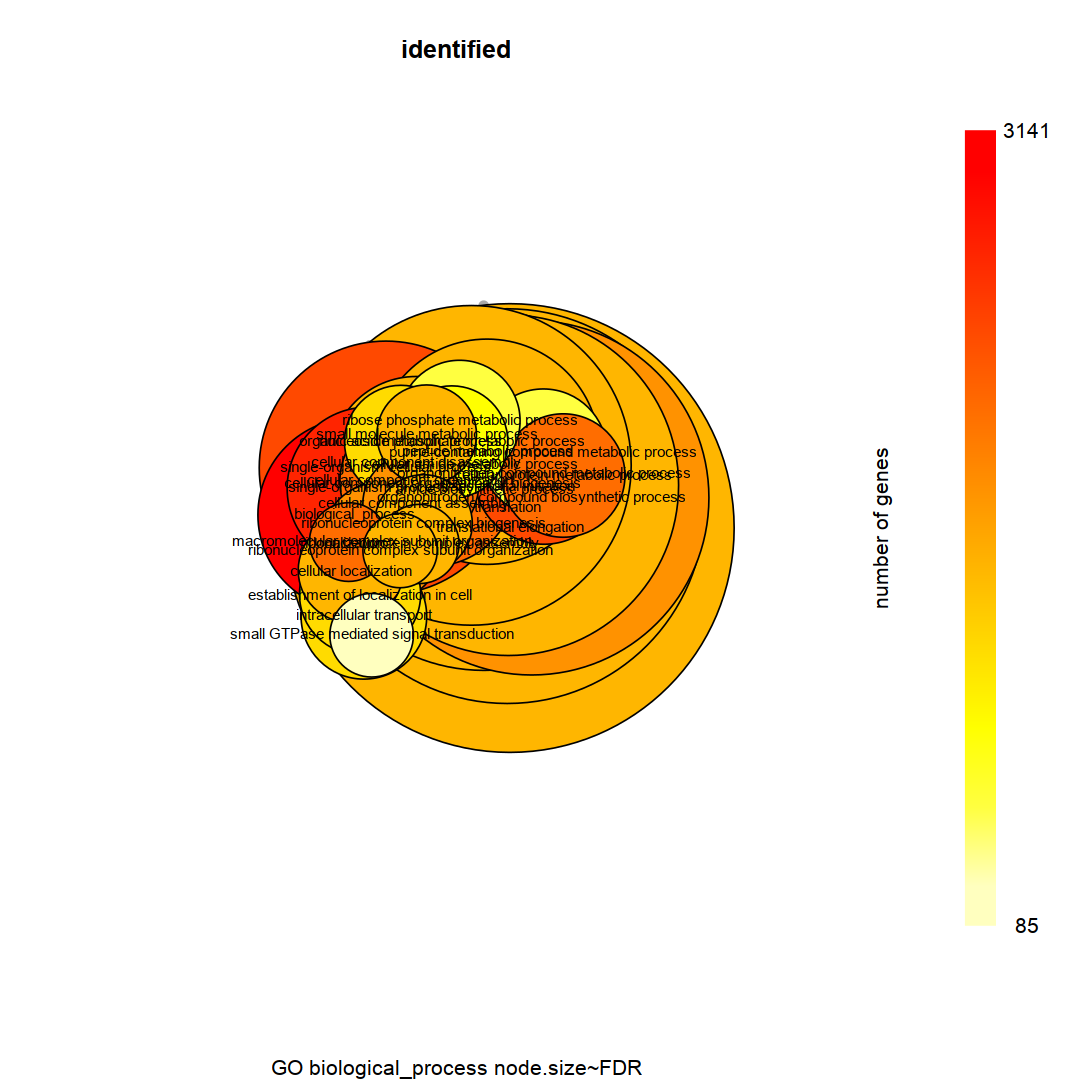

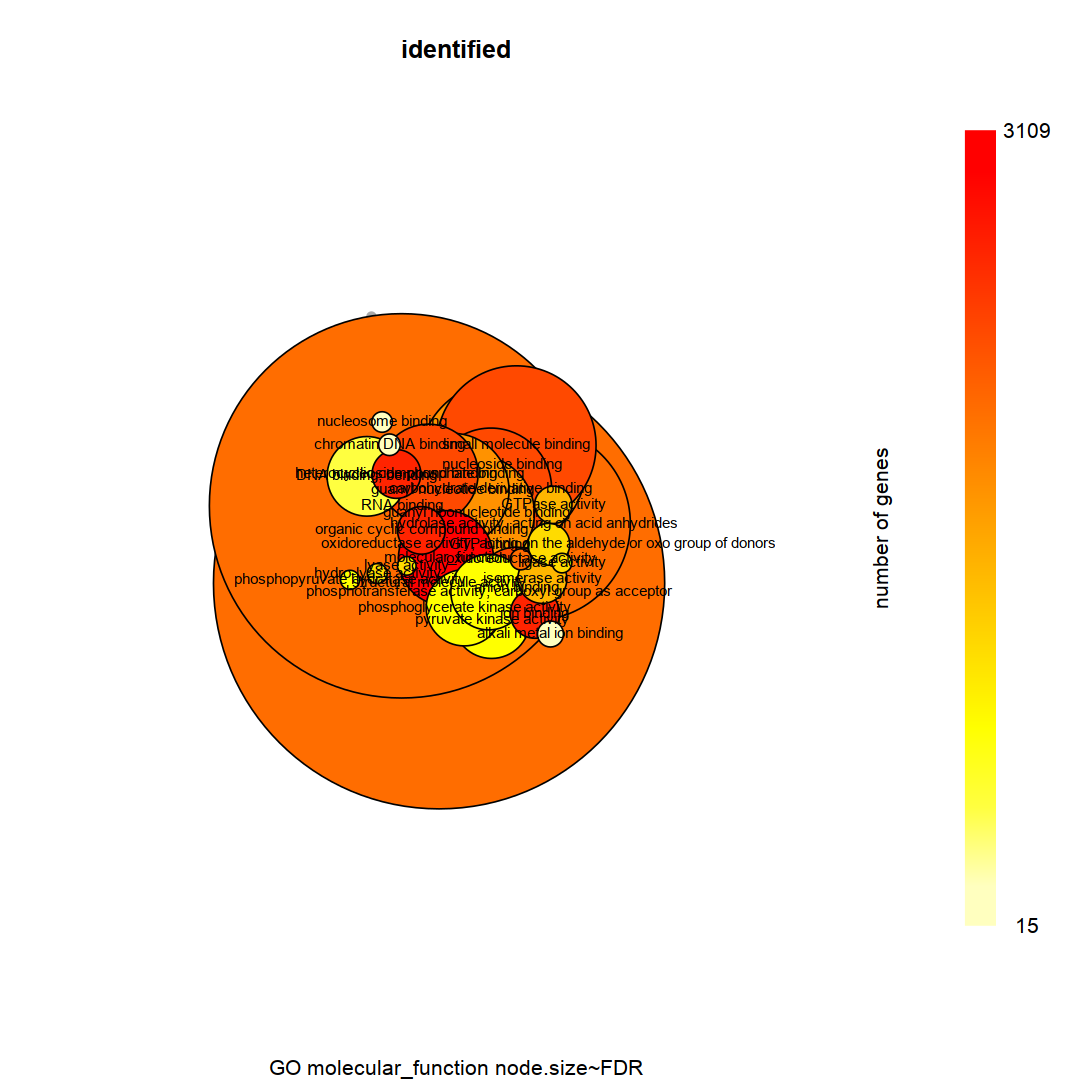

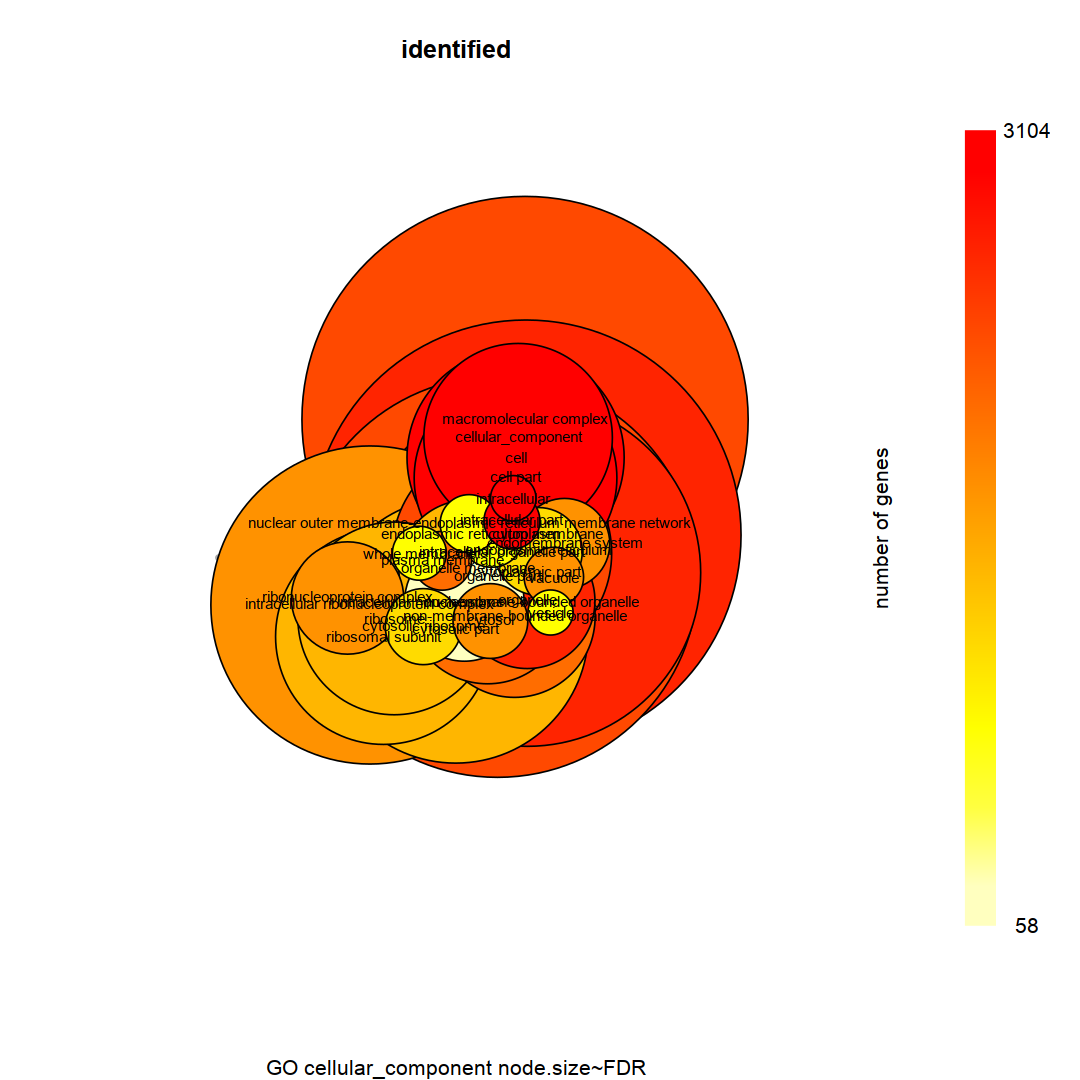

In [10]:
for (i in seq_len(nrow(X))) {
    xx=unlist(X[i,])
    plot_subset(xx[1],xx[2],xx[3],xx[4])
}

In [11]:
plot_subset2=function(group,set,ontology,partition) {

    D=droplevels(d[d$group==group & d$set==set & d$ontology==ontology & d$partition==partition,])
    D=D[order(D$p.adjusted),]
    D$level3=ifelse(is.na(D$level3),D$name,D$level3)
    #D$rank=rank(D$p.adjusted,-D$ic)
    D=D %>%
        group_by(level3) %>%
        mutate(rank = order(order(ic,abs(log(p.adjusted)),  decreasing=FALSE)))
    if (nrow(D)>20) {
        D$term_fil=""
        D$term_fil[D$rank==1]=as.character(D$name[D$rank==1])
    } else {
        D$term_fil=D$name
    }
    tm=get_term_sim_mat(O[[ontology]],Oi[[ontology]] , method = "lin", row_terms = D$ID, col_terms = D$ID)
    TM=max(tm)-tm
    dimnames(TM)=list(O[[ontology]]$name[rownames(TM)],O[[ontology]]$name[colnames(TM)])
    TM=as.dist(TM)
    fit= cmdscale(TM,eig=TRUE, k=2) 
    df=merge(fit$points,D,by.x=0,by.y="name")
    names(df)[1:3]=c("term","dimension1","dimension2")
    df=df[order(df$p.adjusted),]
    colcount=length(unique(df$level3))
    getPalette = colorRampPalette(brewer.pal(12, "Paired"))
    
    p=ggplot(df,aes(x=dimension1,y=dimension2,label=term_fil)) +geom_point(aes(colour=level3,size=abs(log(p.adjusted)))) +
        scale_colour_manual(values=getPalette(colcount), guide= guide_legend(ncol=1) )+
        geom_text_repel(size=2.5,force=2) + 
        theme(legend.text=element_text(size=5),legend.title = element_text(size = 6), legend.key.size = unit(0.5, "cm")) + 
        ggtitle(paste(set,ontology,partition))
    return(p)
}

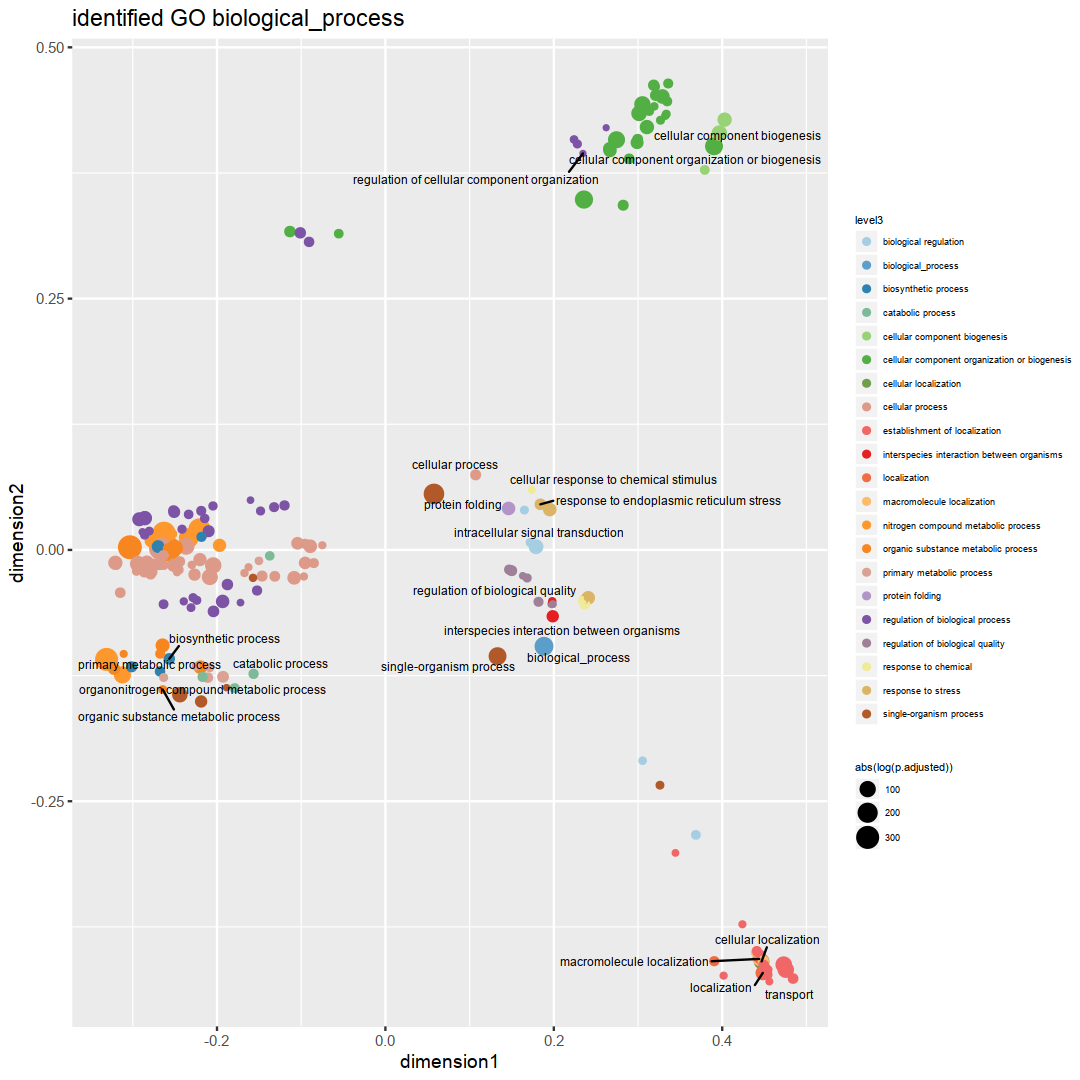

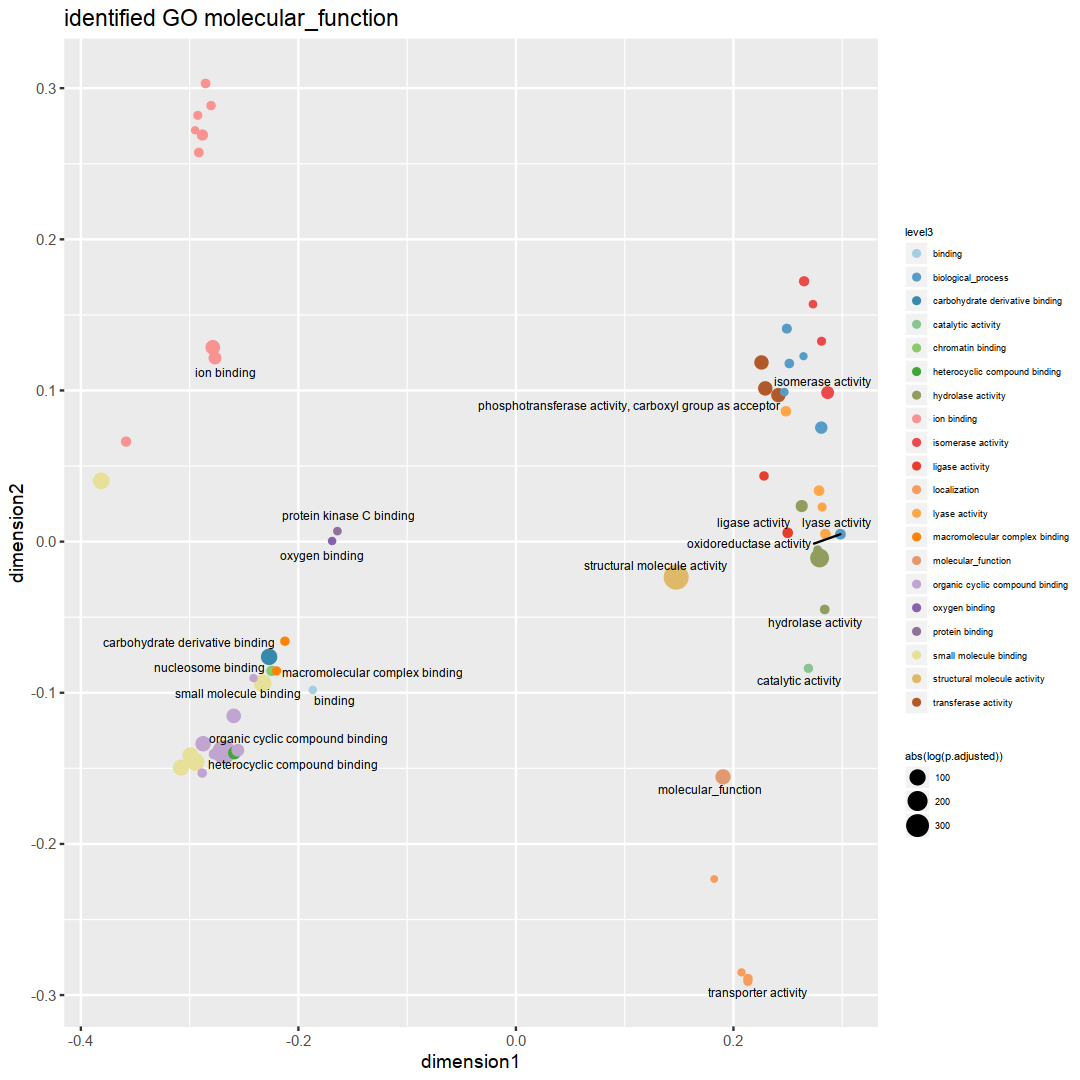

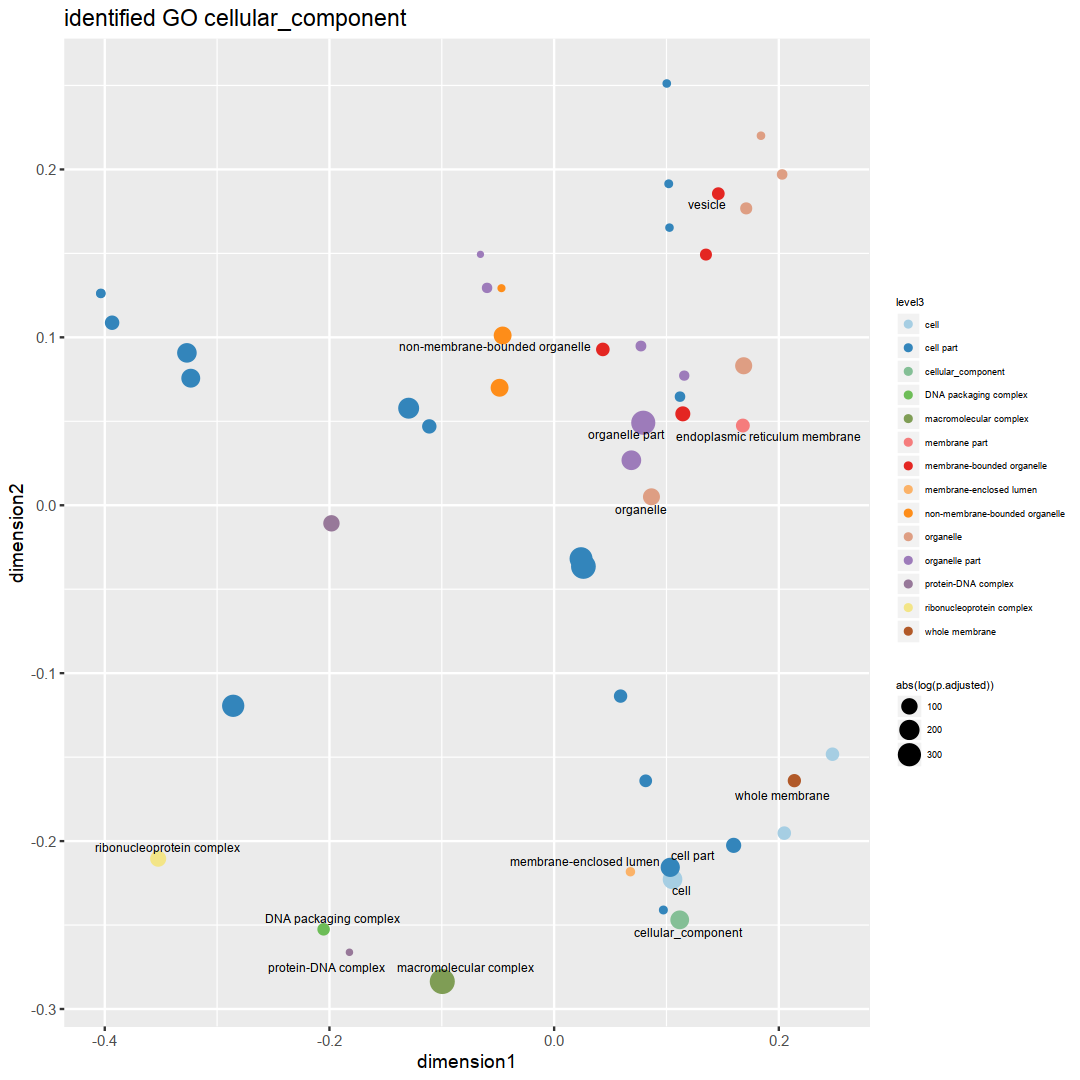

In [12]:
for (i in seq_len(nrow(X))) {
    xx=unlist(X[i,])
    print(plot_subset2(xx[1],xx[2],xx[3],xx[4]))
}

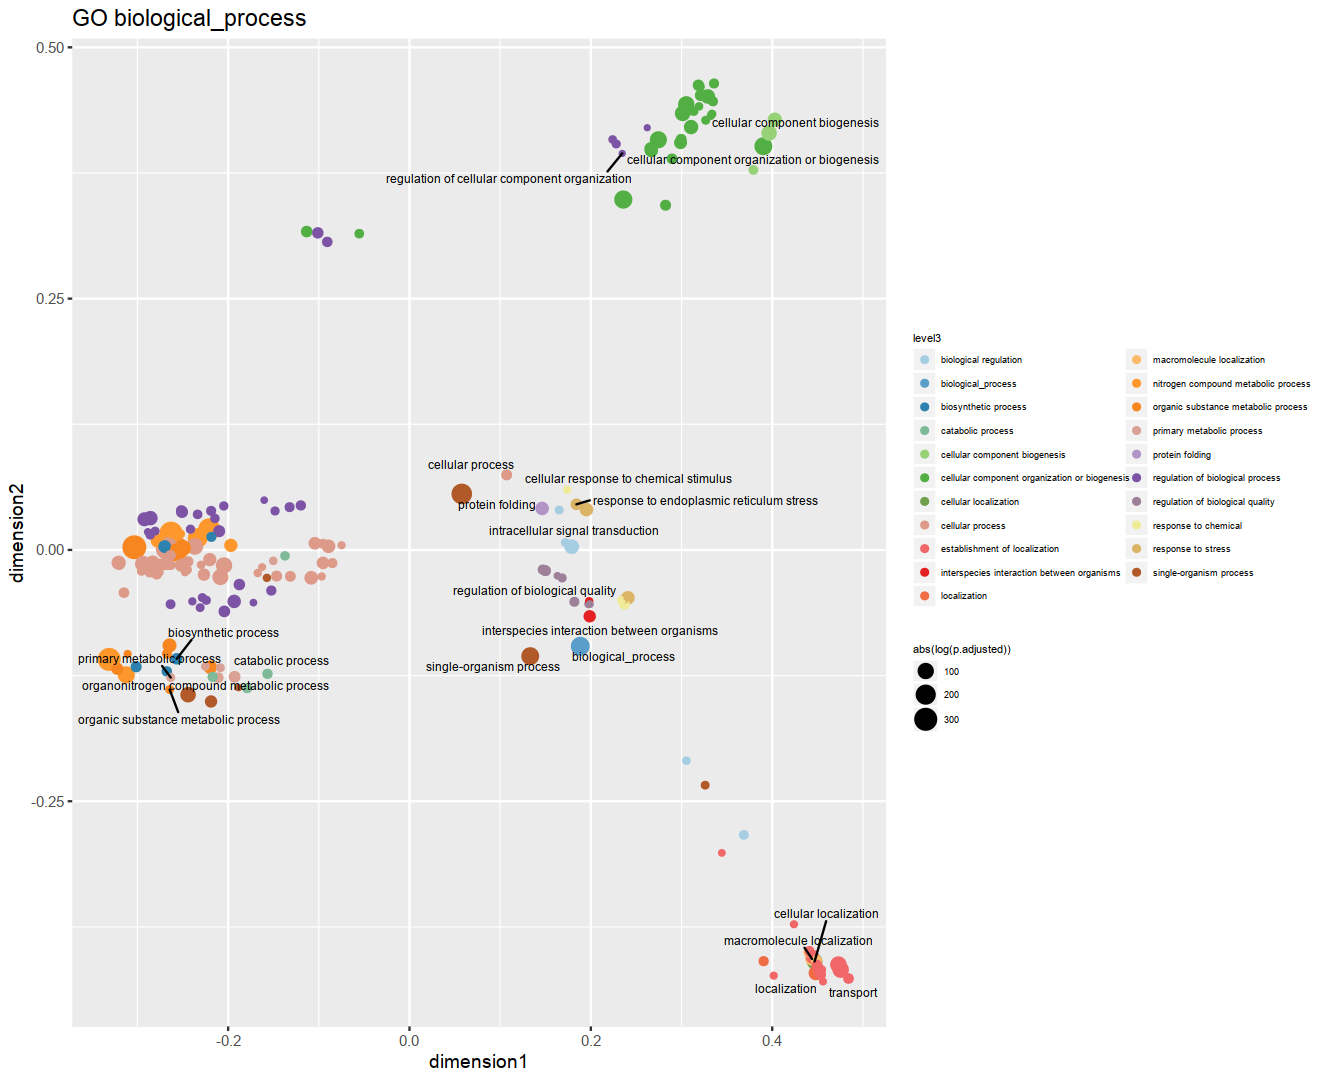

In [41]:
group="proteomics"
set="identified"
ontology="GO"
partition="biological_process"
D=droplevels(d[d$group==group & d$set==set & d$ontology==ontology & d$partition==partition,])
D=D[order(D$p.adjusted),]
D$level3=ifelse(is.na(D$level3),D$name,D$level3)
D=D %>%
    group_by(level3) %>%
    mutate(rank = order(order(ic,abs(log(p.adjusted)),  decreasing=FALSE)))

#D$rank=rank(-D$ic,D$p.adjusted)
D$term_fil=""
D$term_fil[D$rank==1]=as.character(D$name[D$rank==1])
tm=get_term_sim_mat(O[[ontology]],Oi[[ontology]] , method = "lin", row_terms = D$ID, col_terms = D$ID)
TM=max(tm)-tm
dimnames(TM)=list(O[[ontology]]$name[rownames(TM)],O[[ontology]]$name[colnames(TM)])
TM=as.dist(TM)
fit= cmdscale(TM,eig=TRUE, k=2) 
df=merge(fit$points,D,by.x=0,by.y="name")
names(df)[1:3]=c("term","dimension1","dimension2")
df=df[order(df$p.adjusted),]
colcount=length(unique(df$level3))
getPalette = colorRampPalette(brewer.pal(12, "Paired"))

p=ggplot(df,aes(x=dimension1,y=dimension2,label=term_fil)) +geom_point(aes(colour=level3,size=abs(log(p.adjusted)))) +
    scale_colour_manual(values=getPalette(colcount), guide= guide_legend(ncol=2) )+
    geom_text_repel(size=2.5,force=2) + 
    theme(legend.text=element_text(size=5),legend.title = element_text(size = 6), legend.key.size = unit(0.5, "cm")) + 
    ggtitle(paste(ontology,partition))
p

In [43]:
nrow(D[D$rank==1, ])

[1] 21

In [44]:
mod=Mclust(data.frame(fit$points))

In [45]:
options(repr.plot.width=6, repr.plot.height=6)

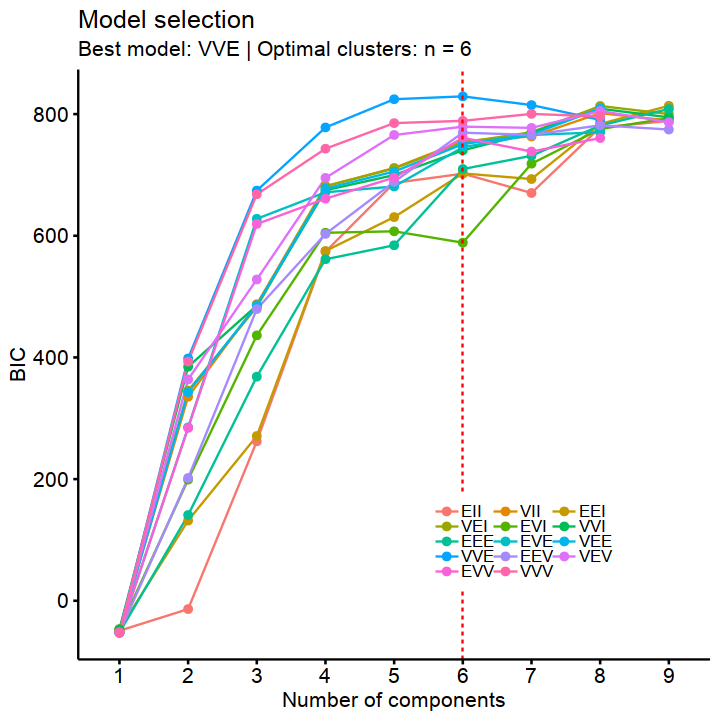

In [46]:
fviz_mclust_bic(mod)

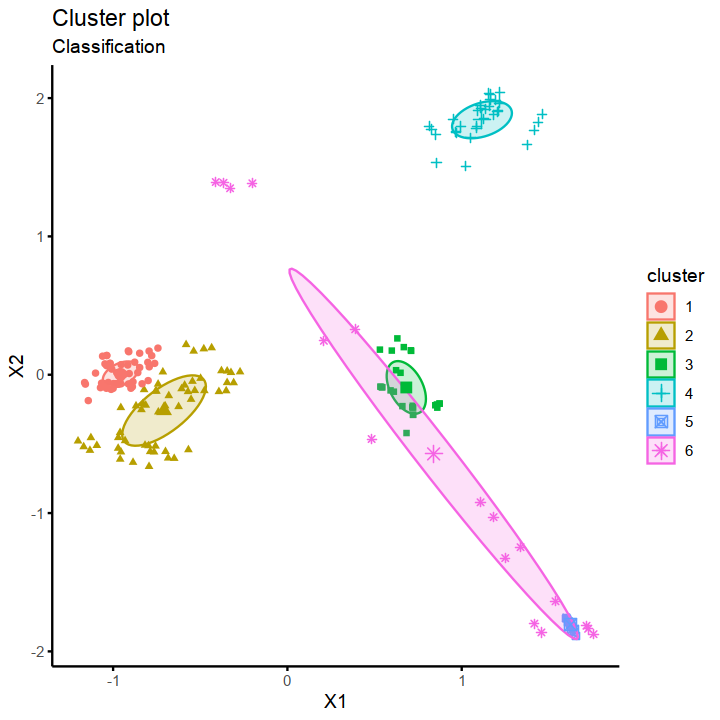

In [47]:
fviz_mclust(mod, "classification",geom="point" )

In [48]:
df=merge(data.frame(mod$data,cluster=mod$classification,uncertainty=mod$uncertainty,mod$z,check.names=F),D,by.x=0,by.y="name")

In [49]:
df=df %>%
    group_by(cluster) %>%
    mutate(clusterrank = order(order(ic,abs(log(p.adjusted)),  decreasing=FALSE)))


In [50]:
head(df)

Row.names,X1,X2,cluster,uncertainty,1,2,3,4,5,⋯,p.adjusted,p.min,depth,ic,partition,level3,loci,rank,term_fil,clusterrank
ADP metabolic process,-0.2756120,-0.02240879,1,0.033697965,0.9663020,3.369796e-02,9.532017e-48,4.000295e-56,0.0000000,⋯,3.099399e-02,2.102859e-114,37,6.821920,biological_process,cellular process,Q42806,38,,50
alpha-amino acid biosynthetic process,-0.2474983,-0.02223012,1,0.144461047,0.8555390,1.444610e-01,4.716754e-42,1.135385e-52,0.0000000,⋯,3.304319e-02,2.239219e-156,26,5.957955,biological_process,cellular process,"P24099,O82560",25,,38
amide biosynthetic process,-0.2629363,0.01662012,1,0.007119611,0.9928804,7.119611e-03,1.499538e-42,2.331687e-51,0.0000000,⋯,6.460403e-133,0.000000e+00,10,4.603143,biological_process,nitrogen compound metabolic process,"P50346,Q39836,O22518",6,,10
amide transport,0.4443077,-0.40477276,5,0.002156249,0.0000000,4.933114e-76,3.096073e-24,2.298369e-159,0.9978438,⋯,1.196126e-16,0.000000e+00,5,4.144396,biological_process,establishment of localization,Q43463,9,,11
ATP generation from ADP,-0.2787903,-0.02408784,1,0.034668281,0.9653317,3.466828e-02,1.749782e-48,1.275874e-56,0.0000000,⋯,4.058782e-08,3.491983e-168,47,7.288009,biological_process,cellular process,Q42806,43,,56
ATP metabolic process,-0.2863153,-0.02226320,1,0.024665689,0.9753343,2.466569e-02,7.600683e-50,2.419820e-57,0.0000000,⋯,1.232156e-06,5.183026e-109,37,6.334905,biological_process,cellular process,Q42806,33,,46


In [51]:
table(df$cluster)


 1  2  3  4  5  6 
57 56 26 31 17 17 

In [52]:
DDD=df[order(df$cluster,df$clusterrank),c("Row.names","level3","cluster","clusterrank","p.adjusted","ic")]

In [53]:
DDD[DDD$cluster==1,]

Row.names,level3,cluster,clusterrank,p.adjusted,ic
cellular nitrogen compound metabolic process,nitrogen compound metabolic process,1,1,1.723272e-03,2.428197
cellular biosynthetic process,biosynthetic process,1,2,7.097854e-06,2.586393
cellular protein metabolic process,organic substance metabolic process,1,3,8.519474e-46,3.060264
organophosphate metabolic process,cellular process,1,4,3.659118e-20,3.921792
nucleobase-containing small molecule metabolic process,cellular process,1,5,2.278614e-27,4.170336
cellular amide metabolic process,nitrogen compound metabolic process,1,6,4.916159e-118,4.269110
nucleoside phosphate metabolic process,cellular process,1,7,1.121726e-41,4.431180
negative regulation of cellular biosynthetic process,regulation of biological process,1,8,6.527399e-04,4.539137
peptide metabolic process,nitrogen compound metabolic process,1,9,2.721948e-83,4.586229
amide biosynthetic process,nitrogen compound metabolic process,1,10,6.460403e-133,4.603143


In [54]:
DDD[DDD$cluster==2,]

Row.names,level3,cluster,clusterrank,p.adjusted,ic
organic substance metabolic process,organic substance metabolic process,2,1,4.638339e-03,1.517737
primary metabolic process,primary metabolic process,2,2,2.598652e-03,1.786241
single-organism metabolic process,single-organism process,2,3,3.527828e-15,1.865955
organonitrogen compound metabolic process,nitrogen compound metabolic process,2,4,9.853192e-52,2.273839
biosynthetic process,biosynthetic process,2,5,8.093143e-11,2.474556
organic substance biosynthetic process,biosynthetic process,2,6,3.914881e-09,2.516795
small molecule metabolic process,single-organism process,2,7,4.976893e-37,2.786119
protein metabolic process,organic substance metabolic process,2,8,1.285657e-13,2.832936
oxidation-reduction process,single-organism process,2,9,8.769567e-02,2.873697
macromolecule biosynthetic process,organic substance metabolic process,2,10,4.366756e-02,3.197840


In [55]:
DDD[DDD$cluster==3,]

Row.names,level3,cluster,clusterrank,p.adjusted,ic
biological_process,biological_process,3,1,1.150254e-71,0.2840353
regulation of biological quality,regulation of biological quality,3,2,9.799942e-06,3.2254135
interspecies interaction between organisms,interspecies interaction between organisms,3,3,2.198793e-15,3.4352058
cellular response to chemical stimulus,response to chemical,3,4,3.064332e-02,3.4472139
"symbiosis, encompassing mutualism through parasitism",interspecies interaction between organisms,3,5,7.722861e-02,3.4925202
intracellular signal transduction,biological regulation,3,6,3.306737e-03,4.5573012
chemical homeostasis,regulation of biological quality,3,7,1.154640e-02,5.0769915
ion homeostasis,regulation of biological quality,3,8,4.874278e-02,5.3200233
response to inorganic substance,response to chemical,3,9,2.278685e-07,5.3831073
cellular homeostasis,regulation of biological quality,3,10,4.734435e-06,5.4454776


In [56]:
DDD[DDD$cluster==4,]

Row.names,level3,cluster,clusterrank,p.adjusted,ic
cellular component organization or biogenesis,cellular component organization or biogenesis,4,1,7.519116e-61,2.527975
cellular component organization,cellular component organization or biogenesis,4,2,1.359700e-51,2.589235
regulation of cellular component organization,regulation of biological process,4,3,9.337898e-02,3.541451
cellular component biogenesis,cellular component biogenesis,4,4,1.295381e-27,3.649601
cellular component assembly,cellular component organization or biogenesis,4,5,2.095860e-37,3.865173
macromolecular complex subunit organization,cellular component organization or biogenesis,4,6,5.001088e-45,4.281399
macromolecular complex assembly,cellular component organization or biogenesis,4,7,3.396731e-10,4.586229
protein complex subunit organization,cellular component organization or biogenesis,4,8,3.673084e-03,4.701656
cellular macromolecular complex assembly,cellular component organization or biogenesis,4,9,4.470666e-04,4.913104
cellular component disassembly,cellular component organization or biogenesis,4,10,1.078856e-63,5.333210


In [57]:
DDD[DDD$cluster==5,]

Row.names,level3,cluster,clusterrank,p.adjusted,ic
localization,localization,5,1,2.467828e-29,2.122153
transport,establishment of localization,5,2,5.260143e-02,2.394845
organic substance transport,establishment of localization,5,3,7.382709e-08,2.945829
nitrogen compound transport,establishment of localization,5,4,1.792564e-12,3.365417
macromolecule localization,macromolecule localization,5,5,6.396928e-23,3.534103
cellular localization,cellular localization,5,6,5.230402e-39,3.559308
ion transmembrane transport,establishment of localization,5,7,1.307307e-07,3.656196
cation transport,establishment of localization,5,8,9.241676e-07,3.796248
protein localization,macromolecule localization,5,9,1.284767e-07,3.902560
cation transmembrane transport,establishment of localization,5,10,1.131118e-08,4.120427


In [58]:
DDD[DDD$cluster==6,]

Row.names,level3,cluster,clusterrank,p.adjusted,ic
single-organism process,single-organism process,6,1,3.173929e-60,0.7237132
cellular process,cellular process,6,2,9.914537e-09,0.8326635
single-organism cellular process,single-organism process,6,3,1.127827e-93,1.4027738
single-organism localization,localization,6,4,2.358884e-06,2.7370974
single-organism transport,establishment of localization,6,5,3.269457e-02,2.7699642
establishment of localization in cell,establishment of localization,6,6,6.004540e-45,4.0359406
intracellular transport,establishment of localization,6,7,1.339443e-46,4.3907172
intracellular protein transport,establishment of localization,6,8,1.051489e-07,5.2243162
transition metal ion transport,establishment of localization,6,9,3.702700e-02,5.8049854
chromatin silencing,cellular component organization or biogenesis,6,10,3.452775e-11,6.9035977


In [63]:
head(df)

Row.names,X1,X2,cluster,uncertainty,1,2,3,4,5,⋯,p.adjusted,p.min,depth,ic,partition,level3,loci,rank,term_fil,clusterrank
ADP metabolic process,-0.2756120,-0.02240879,1,0.033697965,0.9663020,3.369796e-02,9.532017e-48,4.000295e-56,0.0000000,⋯,3.099399e-02,2.102859e-114,37,6.821920,biological_process,cellular process,Q42806,38,,50
alpha-amino acid biosynthetic process,-0.2474983,-0.02223012,1,0.144461047,0.8555390,1.444610e-01,4.716754e-42,1.135385e-52,0.0000000,⋯,3.304319e-02,2.239219e-156,26,5.957955,biological_process,cellular process,"P24099,O82560",25,,38
amide biosynthetic process,-0.2629363,0.01662012,1,0.007119611,0.9928804,7.119611e-03,1.499538e-42,2.331687e-51,0.0000000,⋯,6.460403e-133,0.000000e+00,10,4.603143,biological_process,nitrogen compound metabolic process,"P50346,Q39836,O22518",6,,10
amide transport,0.4443077,-0.40477276,5,0.002156249,0.0000000,4.933114e-76,3.096073e-24,2.298369e-159,0.9978438,⋯,1.196126e-16,0.000000e+00,5,4.144396,biological_process,establishment of localization,Q43463,9,,11
ATP generation from ADP,-0.2787903,-0.02408784,1,0.034668281,0.9653317,3.466828e-02,1.749782e-48,1.275874e-56,0.0000000,⋯,4.058782e-08,3.491983e-168,47,7.288009,biological_process,cellular process,Q42806,43,,56
ATP metabolic process,-0.2863153,-0.02226320,1,0.024665689,0.9753343,2.466569e-02,7.600683e-50,2.419820e-57,0.0000000,⋯,1.232156e-06,5.183026e-109,37,6.334905,biological_process,cellular process,Q42806,33,,46


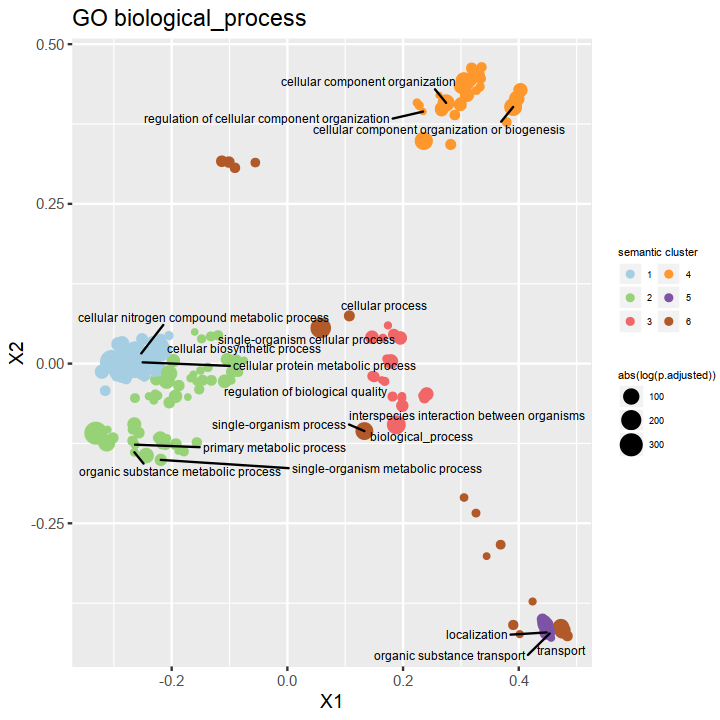

In [70]:
group="proteomics"
set="identified"
ontology="GO"
partition="biological_process"
df2=df
df2$cluster=ordered(df2$cluster)

df2=df2 %>%
    group_by(cluster) %>%
    mutate(rank = order(order(ic,abs(log(p.adjusted)),  decreasing=FALSE)))

df2$term_fil=""
df2$term_fil[df2$rank<=3]=as.character(df2$Row.names[df2$rank<=3])

colcount=length(unique(df2$cluster))
getPalette = colorRampPalette(brewer.pal(12, "Paired"))

p=ggplot(df2,aes(x=X1,y=X2,label=term_fil)) +geom_point(aes(colour=cluster,size=abs(log(p.adjusted)))) +
    scale_colour_manual(values=getPalette(colcount), guide= guide_legend(ncol=2) )+
    geom_text_repel(size=2.5,force=2) + 
    theme(legend.text=element_text(size=5),legend.title = element_text(size = 6), legend.key.size = unit(0.5, "cm")) + 
    ggtitle(paste(ontology,partition)) + 
    labs(colour="semantic cluster")
p

In [71]:
ggsave(p,file=paste0(group,".",set,".pdf"),width=8,height=9)

In [75]:
write.table(df,"analysis//significantly_enriched_terms.Benjamini-Hochberg.subset_GO_BP.clustered.without_geneids.txt",sep="\t",row.names=FALSE,col.names=TRUE,quote=FALSE)